In [220]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
# import logging
from IPython.display import HTML

`animate_agent_path` creates an animation showing the agent's path on a 4x4 grid, with arrows for the optimal policy and the agent's position marked by a red 'A'.

Add -1 in grid for penalty 

In [221]:

grid_world = np.array([
    [0,  0,  0, 10],   
    [0, -1,  0,  0],   
    [0,  0,  0,  0],
    [1,  0,  0,  5]    
])

# Define the movement actions
movement_actions = ['up', 'down', 'left', 'right']
action_indices = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

# Define initial rewards
cell_rewards = {
    (0, 3): 10,
    (1, 1): -1,
    (3, 0): 1,
    (3, 3): 5
}

# Initialize the value function
value_function = np.zeros_like(grid_world, dtype=float)



This part code initializes a 4x4 grid policy where each cell's action is set to 'right', and defines a function to compute the next state based on the current state and action, ensuring the move is within grid boundaries and not into an obstacle.


In [222]:
# Define the policy
policy = np.full((4, 4), 'right', dtype=object)


def compute_next_state(current_state, action):
    current_row, current_col = current_state
    move_row, move_col = action_indices[action]
    next_row, next_col = current_row + move_row, current_col + move_col
    if 0 <= next_row < grid_world.shape[0] and 0 <= next_col < grid_world.shape[1] and grid_world[next_row, next_col] != -1:
        return (next_row, next_col)
    else:
        return current_state

The `update_value_function` computes the value of a state by:
1. Checking if the state is an obstacle and returning 0 if true.
2. Retrieving the action from the policy and calculating the next state.
3. Summing the reward of the next state and the discounted value of the next state to update the value function.

In [223]:
def update_value_function(state, discount_factor):
    row, col = state
    if grid_world[row, col] == -1:
        return 0
    action = policy[row, col]
    next_state = compute_next_state(state, action)
    reward = cell_rewards.get(next_state, 0)
    return reward + discount_factor * value_function[next_state]

1. **Initialization and Iteration:**
   The function  iterates up to a specified number of times, adjusting the value function and policy.

2. **Policy Evaluation:**
   Within each iteration, it updates the value function for each state (except obstacles), calculating the maximum change (delta) to track convergence.

3. **Policy Improvement:**
   After evaluating the value function, it updates the policy by selecting the best action for each state based on the updated values, checking if the policy changes to determine stability.

4. **Convergence Test:**
   If the policy remains unchanged during an iteration, the process stops early, indicating convergence.

5. **Completion:**
   The function prints completion messages and returns the final value function and policy, representing the optimal policy after the iterations.


In [224]:
def run_policy_iteration(value_function, policy, iterations=1000, discount_factor=0.9):
    print("Starting Policy Iteration...")
    for iter in range(1, iterations + 1):
        print(f"Iteration {iter}/{iterations}")
        
        # Evaluation
        delta = 0
        for i in range(4):
            for j in range(4):
                state = (i, j)
                if grid_world[i, j] == -1:
                    continue
                current_value = value_function[state]
                value_function[state] = update_value_function(state, discount_factor)
                delta = max(delta, abs(current_value - value_function[state]))
        
        # Improvement
        policy_stable = True
        for i in range(4):
            for j in range(4):
                state = (i, j)
                if grid_world[i, j] == -1:
                    continue
                action_values = []
                for action in movement_actions:
                    next_state = compute_next_state(state, action)
                    reward = cell_rewards.get(next_state, 0)
                    action_values.append(reward + discount_factor * value_function[next_state])
                best_action = movement_actions[np.argmax(action_values)]
                if policy[state] != best_action:
                    policy_stable = False
                policy[state] = best_action
        
        # Convergence test
        if policy_stable:
            print("Policy iteration converged.")
            break

    print("Policy Iteration Complete.")
    return value_function, policy

# Optimal policy
print("\nFinding Optimal Policy...")
optimal_value_function, optimal_policy = run_policy_iteration(value_function, policy)


Finding Optimal Policy...
Starting Policy Iteration...
Iteration 1/1000
Iteration 2/1000
Iteration 3/1000
Iteration 4/1000
Iteration 5/1000
Iteration 6/1000
Iteration 7/1000
Iteration 8/1000
Iteration 9/1000
Iteration 10/1000
Policy iteration converged.
Policy Iteration Complete.


**display_optimal_policy:**
this function prints symbols for representing optimal policy

In [225]:
def display_optimal_policy(policy):
    action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
    print("\nOptimal Policy:")
    for i in range(4):
        for j in range(4):
            print(action_symbols[policy[i, j]], end=' ')
        print()

display_optimal_policy(optimal_policy)


Optimal Policy:
→ → → ↑ 
↑ → → ↑ 
→ → → ↑ 
→ → → ↑ 


### Explanation of Dynamic Reward Testing

1. **Dynamic Reward Update (`update_rewards` function):**
   - Updates rewards for specific grid cells using random values within predefined ranges.

2. **Agent Testing (`test_agent_with_dynamic_rewards` function):**
   - Initializes the agent at a random starting position in a 4x4 grid.
   - Iteratively applies the optimal policy to move through the grid.
   - Collects rewards dynamically updated by `update_rewards`.
   - Optionally restarts from a random position upon collecting positive rewards.
   - Terminates upon reaching the goal `(3, 3)` or after 100 steps to prevent infinite loops.

3. **Output:**
   - Displays the path taken by the agent (`path_taken`).
   - Shows the total reward collected during the test (`total_reward_collected`).


In [226]:
def update_rewards():
    global cell_rewards
    cell_rewards = {
        (0, 3): np.random.randint(5, 15),
        (1, 1): -np.random.randint(1, 3),
        (3, 0): np.random.randint(0, 2),
        (3, 3): np.random.randint(4, 6)
    }

# Testing agent with dynamic rewards
def test_agent_with_dynamic_rewards(policy):
    state = (np.random.randint(0, 4), np.random.randint(0, 4))  # Random start position
    path = [state]
    total_reward = 0

    print("\nTesting Agent with Optimal Policy from a Random Start Position...")
    for step in range(1, 100):  # Steps to avoid infinite loop
        update_rewards()  # Update rewards dynamically
        if state in cell_rewards:
            total_reward += cell_rewards[state]
        action = policy[state]
        state = compute_next_state(state, action)
        path.append(state)
        if state in cell_rewards and cell_rewards[state] > 0:  # Random restart after collecting a positive reward
            new_row = np.random.randint(0, 4)
            new_col = np.random.randint(0, 4)
            state = (new_row, new_col)
        
        print(f"Step {step}: Moved {action} to {state}. Total reward: {total_reward}")
        
        if state == (3, 3):  # Reached the goal
            print("(3,3) Reached!")
            break
        

    return path, total_reward

path_taken, total_reward_collected = test_agent_with_dynamic_rewards(optimal_policy)
print("\nPath taken by the agent:", path_taken)
print("Total reward collected:", total_reward_collected)



Testing Agent with Optimal Policy from a Random Start Position...
Step 1: Moved up to (2, 3). Total reward: 4
Step 2: Moved up to (1, 3). Total reward: 4
Step 3: Moved up to (0, 1). Total reward: 4
Step 4: Moved right to (0, 2). Total reward: 4
Step 5: Moved right to (2, 1). Total reward: 4
Step 6: Moved right to (2, 2). Total reward: 4
Step 7: Moved right to (2, 3). Total reward: 4
Step 8: Moved up to (1, 3). Total reward: 4
Step 9: Moved up to (0, 2). Total reward: 4
Step 10: Moved right to (0, 3). Total reward: 4
Step 11: Moved up to (0, 0). Total reward: 17
Step 12: Moved right to (0, 1). Total reward: 17
Step 13: Moved right to (0, 2). Total reward: 17
Step 14: Moved right to (3, 2). Total reward: 17
Step 15: Moved right to (0, 2). Total reward: 17
Step 16: Moved right to (3, 1). Total reward: 17
Step 17: Moved right to (3, 2). Total reward: 17
Step 18: Moved right to (3, 2). Total reward: 17
Step 19: Moved right to (0, 3). Total reward: 17
Step 20: Moved up to (2, 3). Total rewa

The `plot_grid_and_policy` function visualizes a 4x4 grid with arrows representing the policy for each cell, displaying obstacles as 'X' and rewards based on `cell_rewards`.


In [227]:
def plot_grid_and_policy(grid, policy):
    fig, ax = plt.subplots()

    action_arrows = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}

    # Plot grid cells
    for i in range(4):
        for j in range(4):
            reward = cell_rewards.get((i, j), 0)
            if grid_world[i, j] == -1:
                cell_text = 'X'
            else:
                cell_text = action_arrows[policy[i, j]]
            ax.text(j, i, cell_text, va='center', ha='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.9'))

    # Set up the grid lines and labels
    ax.set_xticks(np.arange(-0.5, 4, 1))
    ax.set_yticks(np.arange(-0.5, 4, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(3.5, -0.5)

    plt.show()

`plot_grid_and_policy` visualizes a 4x4 grid with arrows showing the optimal policy for each cell, handling obstacles(X) and rewards.
`plot_value_function_heatmap` creates a heatmap to visualize the optimal value function across the grid, using a coolwarm color map.


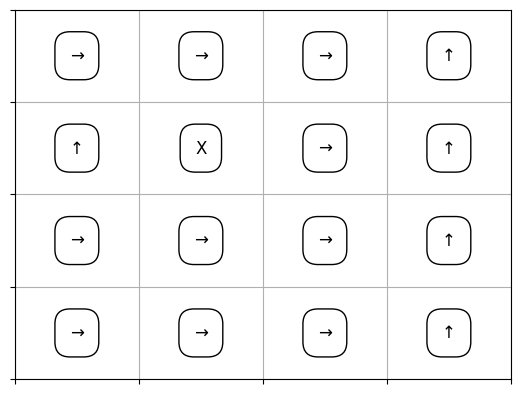

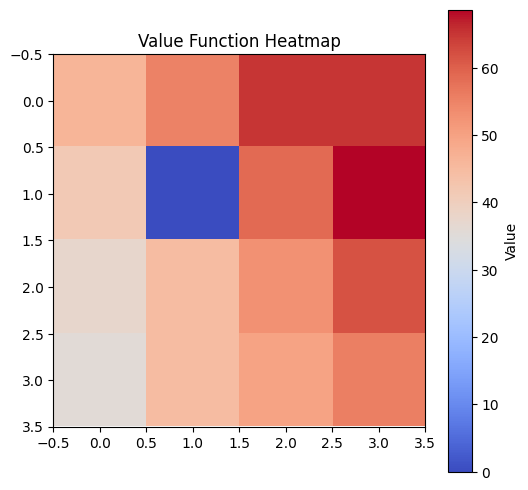

In [228]:
plot_grid_and_policy(grid_world, optimal_policy)

# Plotting value function heatmap
def plot_value_function_heatmap(value_function):
    plt.figure(figsize=(6, 6))
    plt.imshow(value_function, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title('Value Function Heatmap')
    plt.show()

plot_value_function_heatmap(optimal_value_function)

`animate_agent_path` generates an animated visualization of the agent's path (`path`) on a 4x4 grid, displaying the optimal policy arrows and marking the agent's movement with a red 'A'.


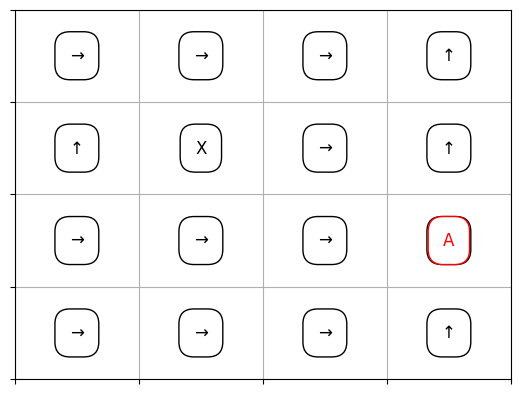

In [229]:
def animate_agent_path(path):
    fig, ax = plt.subplots()

    action_arrows = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}

    def update_animation_frame(i):
        ax.clear()
        for x in range(4):
            for y in range(4):
                reward = cell_rewards.get((x, y), 0)
                if grid_world[x, y] == -1:
                    cell_text = 'X'
                else:
                    cell_text = action_arrows[optimal_policy[x, y]]
                ax.text(y, x, cell_text, va='center', ha='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.9'))

        state = path[i]
        ax.text(state[1], state[0], 'A', va='center', ha='center', fontsize=12, color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.9'))
        ax.set_xticks(np.arange(-0.5, 4, 1))
        ax.set_yticks(np.arange(-0.5, 4, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True)
        ax.set_xlim(-0.5, 3.5)
        ax.set_ylim(3.5, -0.5)

    animation_instance = animation.FuncAnimation(fig, update_animation_frame, frames=len(path), interval=500, repeat=False)
    return HTML(animation_instance.to_jshtml())

animate_agent_path(path_taken)
